In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from keras.models import Model
from keras.layers import Dense, concatenate
from keras import Input
from keras.utils import plot_model
from keras.callbacks import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model

Le dataset contient les caractéristiques de maisons (surface, nombre de chambres, si la maison a du terrain ou pas, le nombre d’étages…). En tout, il y a 16 caractéristiques. Le modèle doit être capable de prédire le prix d’une maison en fonction de ses caractéristiques en dizaines de milliers de dollars. Par exemple, si le modèle renvoie 255.6, c’est que le prix de la maison est estimé à 255600 dollars. 

Dans ce dataset, il y a 8000 données d’entraînement et 1000 données test. Le jupyter notebook starter_code_regression vous permet de lire les données. 

In [3]:
# The data describe the characteristics of a house (surface, number of rooms...)
# and you should predict its price

# The metrics for the ranking will be based on the mean square error ('mse')

df_train = pd.read_csv("Train.csv")
df_train.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,77747,50,1,1,72,98938,8,10,2014,0,1,4829,4204,455,0,3,7786197.4
1,28459,52,0,0,4,50114,1,7,2012,1,1,3570,9363,318,0,6,2846923.2
2,34668,69,1,1,12,17366,8,7,2002,0,1,3476,7549,503,1,7,3475230.2
3,64335,4,0,0,83,65939,6,9,2020,1,0,7301,6989,802,0,1,6435779.0
4,22875,86,1,0,95,8661,5,7,1994,0,0,6394,2119,542,0,7,2295511.4


In [4]:
df_test = pd.read_csv("Test.csv")
df_test.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,92649,31,0,0,77,56098,10,8,1991,1,1,6811,2656,429,1,8,9271774.1
1,42485,1,0,0,40,23782,7,7,2017,0,1,974,9553,426,0,3,4251851.7
2,65867,37,0,0,92,67725,6,2,1994,1,1,3054,4650,998,1,10,6593211.4
3,2372,41,1,0,5,60320,1,1,2003,0,0,8041,7294,736,1,4,241014.3
4,60514,46,1,1,35,76413,2,1,2019,1,0,9227,737,340,0,8,6059360.9


In [5]:
# Separate input data/output data and store into numpy array

X_train = np.array(df_train.drop('price', axis=1))
y_train = np.array(df_train['price'])/10000

X_test = np.array(df_test.drop('price', axis=1))
y_test = np.array(df_test['price'])/10000

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8000, 16) (8000,)
(1000, 16) (1000,)


Dans un premier temps, vous devez faire un modèle qui a la même structure que celui montré dans model_graph.png. Ce modèle utilisera uniquement les données d’apprentissage et chacune des 16 features du dataset sera envoyée dans une des 16 entrées du réseau de neurones. 

In [7]:
# define model
x = [[] for _ in range(16)]

act = 'relu' # activation function
n = 16 # number of inputs
h = int(np.log2(8) -1) # number of "hiddden" groups of c layers
c = 3 # number of layers before concatenating neurons


for i in range(n):
    x[0].append(Input(shape =(16,)))
    x[1].append(Dense(3, activation = act)(x[0][i]))
    x[2].append(Dense(3, activation = act)(x[1][i]))
    x[3].append(Dense(3, activation = act)(x[2][i]))
# ok

for i in range(n //2):
    x[4].append(concatenate([x[3][2 * i], x[3][(2 * i) +1]]))
    x[5].append(Dense(5, activation = act)(x[4][i]))
    x[6].append(Dense(5, activation = act)(x[5][i]))

for i in range(n //4):
    x[7].append(concatenate([x[6][2 * i], x[6][(2 * i) +1], x[3][((i * n) //4) + 0], x[3][((i * n) //4) + 1], x[3][((i * n) //4) + 2], x[3][((i * n) //4) + 3]]))
    x[8].append(Dense(8, activation = act)(x[7][i]))
    x[9].append(Dense(8, activation = act)(x[8][i]))

for i in range(n //8):
    x[10].append(concatenate([x[9][2 * i], x[9][(2 * i) +1]]))
    x[11].append(Dense(16, activation = act)(x[10][i]))
    x[12].append(Dense(16, activation = act)(x[11][i]))


for i in range(n //16):
    x[13].append(concatenate([x[12][2 * i], x[12][(2 * i) +1]]))
    x[14].append(Dense(256, activation = act)(x[13][i]))
    x[15].append(Dense(1)(x[14][i]))

model = Model(inputs = x[0], outputs = x[15])

In [8]:
model.summary()
plot_model(model, show_shapes =True, to_file ='model_graph2.png')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │         51 │ input_layer[0][0

 Total params: 12,537 (48.97 KB)

 Trainable params: 12,537 (48.97 KB)

 Non-trainable params: 0 (0.00 B)

: 

In [9]:
X_train_min = np.min(X_train, axis=0)
X_train_max = np.max(X_train, axis=0)
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)

X_test_min = np.min(X_test, axis=0)
X_test_max = np.max(X_test, axis=0)
X_test = (X_test - X_test_min) / (X_test_max - X_test_min)

In [10]:
# Split X_train into individual inputs
X_train_split = [X_train[:, i].reshape(8000, 1) for i in range(16)]


callbacks = [
    EarlyStopping(monitor = 'mse', patience =5),
    ModelCheckpoint(
        filepath = 'my_best_model.hdf5',
        monitor = 'mse',
        mode = 'min',
        save_best_only = True,
        verbose =0)
]

model.compile(optimizer ='rmsprop', loss ='mse', metrics =['mse'])
hist = model.fit([X_train] * 16, y_train, epochs =100, batch_size =32, callbacks = callbacks)

Epoch 1/100
250/250 [==============================] - 14s 39ms/step - loss: 126530.1797 - mse: 126530.1797
Epoch 2/100
250/250 [==============================] - 9s 38ms/step - loss: 30589.5391 - mse: 30589.5391
Epoch 3/100
250/250 [==============================] - 9s 37ms/step - loss: 1779.7166 - mse: 1779.7166
Epoch 4/100
250/250 [==============================] - 10s 38ms/step - loss: 904.7411 - mse: 904.7411
Epoch 5/100
250/250 [==============================] - 9s 38ms/step - loss: 682.4980 - mse: 682.4980
Epoch 6/100
250/250 [==============================] - 9s 37ms/step - loss: 567.2354 - mse: 567.2354
Epoch 7/100
250/250 [==============================] - 9s 37ms/step - loss: 498.2101 - mse: 498.2101
Epoch 8/100
250/250 [==============================] - 9s 38ms/step - loss: 448.0099 - mse: 448.0099
Epoch 9/100
250/250 [==============================] - 10s 39ms/step - loss: 422.7064 - mse: 422.7064
Epoch 10/100
250/250 [==============================] - 9s 37ms/step - loss:

Text(0.5, 1.0, 'Training loss')

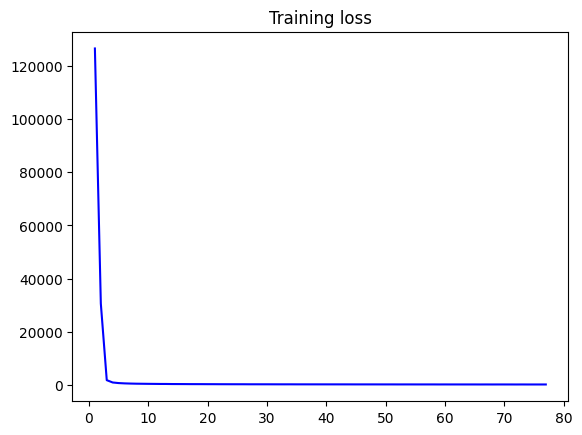

In [11]:
train_loss = hist.history['loss']
ep = range(1, len(train_loss) +1)

plt.plot(ep, train_loss, 'b-')
plt.title("Training loss")

32/32 [==============================] - 0s 9ms/step


Text(0.5, 1.0, 'Visualisation on sq meters')

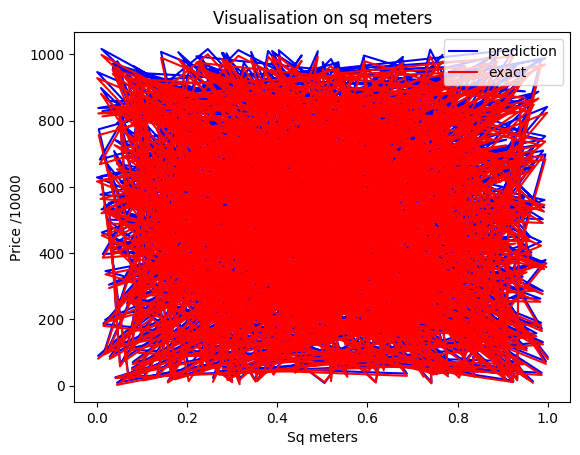

In [21]:
# Split X_train into individual inputs
X_test_split = [X_test[:, i].reshape(1000, 1) for i in range(16)]

y_p = model.predict([X_test] * 16)

plt.plot(X_test[:, 11], y_p, 'b-' )
plt.plot(X_test[:, 11], y_test, 'r-')

plt.xlabel("Sq meters")
plt.ylabel("Price /10000")
plt.legend(("prediction", "exact"))
plt.title("Visualisation on sq meters")

Dans un deuxième temps, vous devez mettre en place le K-Fold avec K=5. Le nombre d’epoch optimal de chacun des 5 modèle sera déterminé en utilisant le callbacks de Keras. Le modèle final sera la moyenne des 5 modèles et sera testé sur les données test. 

In [13]:
def create_model(X_train, y_train, count):
    callbacks = [
        EarlyStopping(monitor = 'mse', patience =5),
        ModelCheckpoint(
            filepath = 'my_best_model' + str(count) + '.hdf5',
            monitor = 'mse',
            mode = 'min',
            save_best_only = True,
            verbose =0)
    ]

    model = Model(inputs = x[0], outputs = x[15])

    
    model.compile(optimizer ='rmsprop', loss ='mse', metrics =['mse'])
    hist = model.fit([X_train] * 16, y_train, epochs =100, batch_size =32, callbacks = callbacks)

    return model

In [25]:
n_folds = 5
# définir la validation croisée à n plis
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=0)

# créer une liste vide pour stocker les résultats
cv_score = []
count = 1

for train_index, val_index in kfold.split(X_train, y_train):
    # créer le modèle en appelant la fonction create_model
    model = create_model(X_train[train_index], y_train[train_index], count)
    print(count)
    count += 1
    
    # évaluer le modèle
    # Passer les données sous la forme d'une liste
    score = model.evaluate([X_train[val_index]] * 16, y_train[val_index], verbose=1) 
    print(model.metrics_names[1], score[1] * 100)
    cv_score.append(score[1] * 100)

print("average mse and standard deviation: ", np.mean(cv_score), np.std(cv_score))


Epoch 1/100
200/200 [==============================] - 12s 38ms/step - loss: 155.1381 - mse: 155.1381
Epoch 2/100
200/200 [==============================] - 8s 39ms/step - loss: 139.9471 - mse: 139.9471
Epoch 3/100
200/200 [==============================] - 7s 36ms/step - loss: 142.1261 - mse: 142.1261
Epoch 4/100
200/200 [==============================] - 8s 38ms/step - loss: 144.3427 - mse: 144.3427
Epoch 5/100
200/200 [==============================] - 7s 35ms/step - loss: 140.4567 - mse: 140.4567
Epoch 6/100
200/200 [==============================] - 8s 38ms/step - loss: 139.0157 - mse: 139.0157
Epoch 7/100
200/200 [==============================] - 7s 37ms/step - loss: 141.1587 - mse: 141.1587
Epoch 8/100
200/200 [==============================] - 8s 38ms/step - loss: 138.8566 - mse: 138.8566
Epoch 9/100
200/200 [==============================] - 8s 38ms/step - loss: 143.0525 - mse: 143.0525
Epoch 10/100
200/200 [==============================] - 7s 37ms/step - loss: 134.0277 - ms

In [26]:
all_model = []
for i in range(n_folds):
    all_model.append(load_model('my_best_model' + str(i+1) + '.hdf5'))

In [27]:
model_predict_mean = all_model[0].predict([X_test] * 16)

for i in range(1, n_folds):
    model_predict_mean += all_model[i].predict([X_test] * 16)

model_predict_mean = np.round(model_predict_mean /n_folds)


# final model
print("Mean error: ", (np.sum(np.abs(model_predict_mean[:, 0] - y_test)) / len(y_test)))

32/32 [==============================] - 1s 7ms/step
Mean error:  0.7469203999999983
